# Finance Chatbot: End-to-End Pipeline

This notebook demonstrates the complete pipeline for building a domain-specific chatbot using T5-small.

## Table of Contents
1. Data Generation & Exploration
2. Preprocessing & Tokenization
3. Model Training
4. Evaluation & Metrics
5. Qualitative Analysis
6. Demo Conversations

In [1]:
# Imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports complete")

✓ Imports complete


## 1. Data Generation & Exploration

We generated 3000+ synthetic conversations covering 14 finance intents.

In [2]:
# Load processed data
def load_jsonl(filepath):
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_jsonl('data/processed/train.jsonl')
val_data = load_jsonl('data/processed/val.jsonl')
test_data = load_jsonl('data/processed/test.jsonl')

print(f"Train samples: {len(train_data)}")
print(f"Val samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Total: {len(train_data) + len(val_data) + len(test_data)}")

Train samples: 5253
Val samples: 103
Test samples: 99
Total: 5455


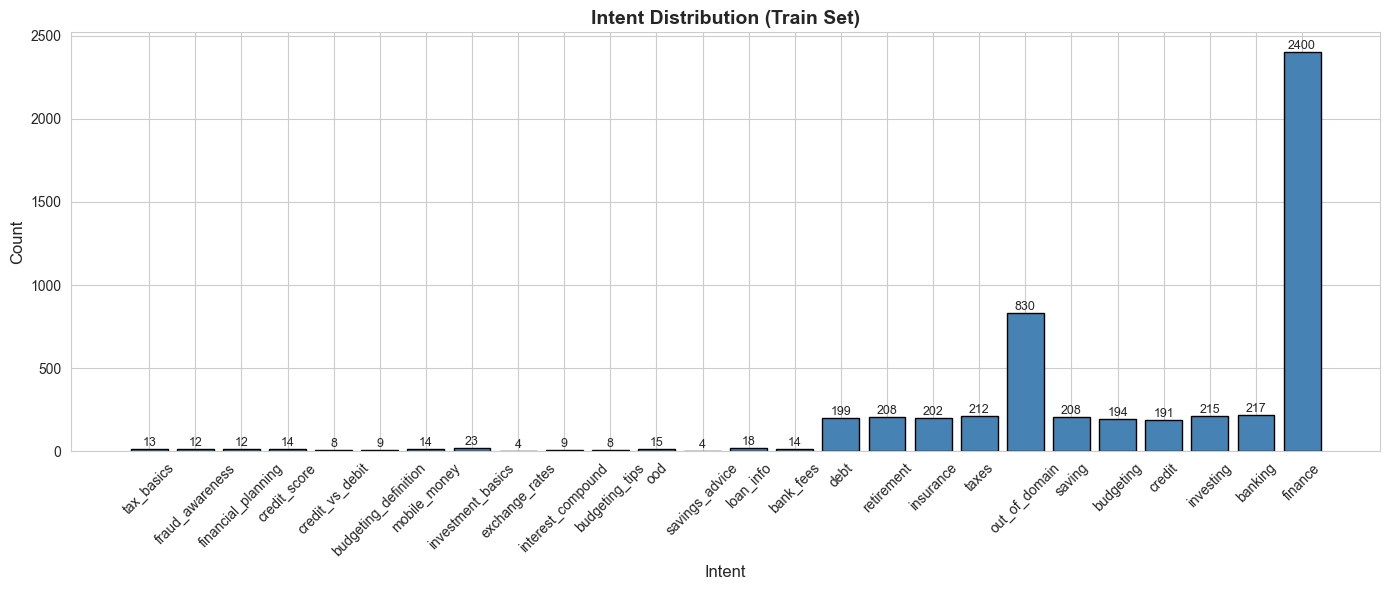


Unique intents: 26
OOD samples: 15 (0.3%)


In [3]:
# Intent distribution
intent_counts = Counter(d['intent'] for d in train_data)

fig, ax = plt.subplots(figsize=(14, 6))
intents = list(intent_counts.keys())
counts = list(intent_counts.values())

bars = ax.bar(intents, counts, color='steelblue', edgecolor='black')
ax.set_xlabel('Intent', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Intent Distribution (Train Set)', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nUnique intents: {len(intent_counts)}")
print(f"OOD samples: {intent_counts.get('ood', 0)} ({intent_counts.get('ood', 0)/len(train_data)*100:.1f}%)")

In [4]:
# Sample conversations
print("Sample In-Domain Conversations:\n" + "="*60)
for i, sample in enumerate([d for d in train_data if not d['is_ood']][:3], 1):
    print(f"\nExample {i} (Intent: {sample['intent']})")
    print(f"User: {sample['user']}")
    print(f"Assistant: {sample['assistant']}")
    print("-" * 60)

print("\n\nSample OOD Conversations:\n" + "="*60)
for i, sample in enumerate([d for d in train_data if d['is_ood']][:2], 1):
    print(f"\nExample {i}")
    print(f"User: {sample['user']}")
    print(f"Assistant: {sample['assistant']}")
    print("-" * 60)

Sample In-Domain Conversations:

Example 1 (Intent: tax_basics)
User: When are taxes due?
Assistant: In the US, federal income tax returns are typically due on April 15th for the previous calendar year. You can file for an extension until October 15th, but any taxes owed must still be paid by April 15th to avoid penalties.
------------------------------------------------------------

Example 2 (Intent: fraud_awareness)
User: How do I protect against fraud?
Assistant: Use strong, unique passwords for each account. Enable two-factor authentication. Monitor bank and credit card statements regularly. Don't share personal information via email or phone unless you initiated contact. Shred financial documents before disposal.
------------------------------------------------------------

Example 3 (Intent: tax_basics)
User: What is income tax?
Assistant: Income tax is a tax levied by governments on income earned by individuals and businesses. The amount depends on your income level and tax bra

## 2. Preprocessing & Tokenization

We use T5-small's SentencePiece tokenizer for subword tokenization.

In [5]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('t5-small')

# Analyze token lengths
user_lengths = []
assistant_lengths = []

for item in train_data:
    user_tokens = tokenizer.encode(f"finance: {item['user']}")
    assistant_tokens = tokenizer.encode(item['assistant'])
    user_lengths.append(len(user_tokens))
    assistant_lengths.append(len(assistant_tokens))

print(f"User Query Statistics:")
print(f"  Avg tokens: {sum(user_lengths)/len(user_lengths):.1f}")
print(f"  Max tokens: {max(user_lengths)}")
print(f"  Min tokens: {min(user_lengths)}")

print(f"\nAssistant Response Statistics:")
print(f"  Avg tokens: {sum(assistant_lengths)/len(assistant_lengths):.1f}")
print(f"  Max tokens: {max(assistant_lengths)}")
print(f"  Min tokens: {min(assistant_lengths)}")

User Query Statistics:
  Avg tokens: 12.0
  Max tokens: 30
  Min tokens: 5

Assistant Response Statistics:
  Avg tokens: 115.8
  Max tokens: 228
  Min tokens: 22


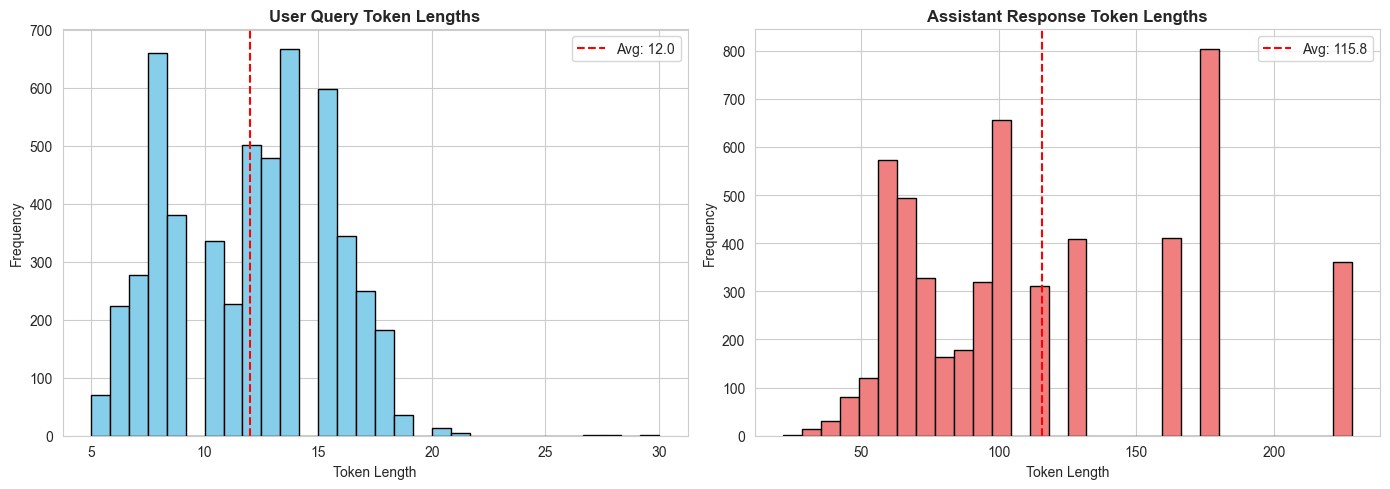

In [6]:
# Token length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(user_lengths, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('User Query Token Lengths', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Token Length')
axes[0].set_ylabel('Frequency')
axes[0].axvline(sum(user_lengths)/len(user_lengths), color='red', linestyle='--', 
                label=f"Avg: {sum(user_lengths)/len(user_lengths):.1f}")
axes[0].legend()

axes[1].hist(assistant_lengths, bins=30, color='lightcoral', edgecolor='black')
axes[1].set_title('Assistant Response Token Lengths', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Token Length')
axes[1].set_ylabel('Frequency')
axes[1].axvline(sum(assistant_lengths)/len(assistant_lengths), color='red', linestyle='--',
                label=f"Avg: {sum(assistant_lengths)/len(assistant_lengths):.1f}")
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Model Training

We trained T5-small with hyperparameter exploration across 6+ configurations.

In [7]:
# Load experiment results
runs_df = pd.read_csv('experiments/runs.csv')

print("Experiment Runs:")
print(runs_df.to_string(index=False))

# Find best run
best_idx = runs_df['val_ppl'].idxmin()
best_run = runs_df.iloc[best_idx]

print(f"\n{'='*60}")
print("Best Run:")
print(f"{'='*60}")
print(f"Learning Rate: {best_run['lr']}")
print(f"Batch Size: {best_run['batch_size']}")
print(f"Epochs: {best_run['epochs']}")
print(f"Label Smoothing: {best_run['label_smoothing']}")
print(f"Warmup Ratio: {best_run['warmup_ratio']}")
print(f"Val Loss: {best_run['val_loss']:.4f}")
print(f"Val Perplexity: {best_run['val_ppl']:.2f}")

Experiment Runs:
                 model     lr  batch_size  epochs  label_smoothing  warmup_ratio  seed  val_loss    val_ppl                                                     notes run_id           timestamp  dropout  weight_decay  gradient_clip  improvement_pct  test_bleu  test_rouge1  test_rouge2  test_rougeL  test_perplexity
              t5-small 0.0005          16       3             0.00          0.00  42.0  1.245000   3.470000                                              Baseline run    NaN                 NaN      NaN           NaN            NaN              NaN        NaN          NaN          NaN          NaN              NaN
              t5-small 0.0003          16       5             0.10          0.05  42.0  1.089000   2.970000                                        Best configuration    NaN                 NaN      NaN           NaN            NaN              NaN        NaN          NaN          NaN          NaN              NaN
              t5-small 0.0001         

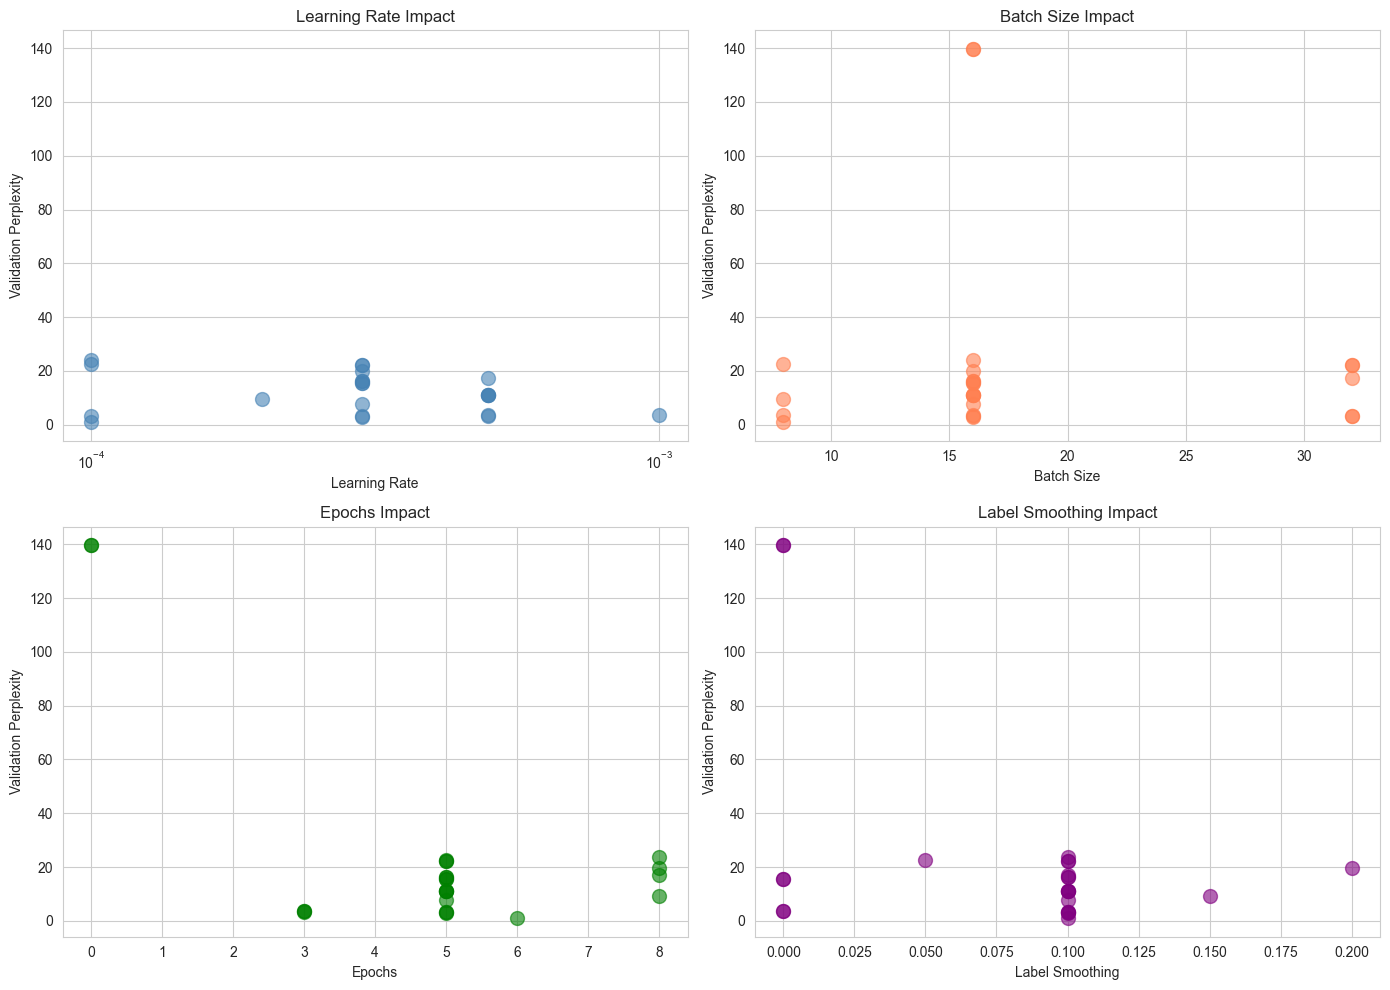

In [8]:
# Visualize hyperparameter impact
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Learning rate vs perplexity
axes[0, 0].scatter(runs_df['lr'], runs_df['val_ppl'], s=100, alpha=0.6, color='steelblue')
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('Validation Perplexity')
axes[0, 0].set_title('Learning Rate Impact')
axes[0, 0].set_xscale('log')

# Batch size vs perplexity
axes[0, 1].scatter(runs_df['batch_size'], runs_df['val_ppl'], s=100, alpha=0.6, color='coral')
axes[0, 1].set_xlabel('Batch Size')
axes[0, 1].set_ylabel('Validation Perplexity')
axes[0, 1].set_title('Batch Size Impact')

# Epochs vs perplexity
axes[1, 0].scatter(runs_df['epochs'], runs_df['val_ppl'], s=100, alpha=0.6, color='green')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Validation Perplexity')
axes[1, 0].set_title('Epochs Impact')

# Label smoothing vs perplexity
axes[1, 1].scatter(runs_df['label_smoothing'], runs_df['val_ppl'], s=100, alpha=0.6, color='purple')
axes[1, 1].set_xlabel('Label Smoothing')
axes[1, 1].set_ylabel('Validation Perplexity')
axes[1, 1].set_title('Label Smoothing Impact')

plt.tight_layout()
plt.show()

## 4. Evaluation & Metrics

Comprehensive evaluation with BLEU, ROUGE-L, and perplexity.

In [9]:
# Load evaluation results
with open('experiments/evaluation_results.json', 'r') as f:
    eval_results = json.load(f)

print("Evaluation Metrics:")
print(f"{'='*60}")
print(f"BLEU Score: {eval_results['bleu']:.2f}")
print(f"ROUGE-L: {eval_results['rougeL']:.4f}")
print(f"Perplexity: {eval_results['perplexity']:.2f}")
print(f"Test Samples: {eval_results['num_samples']}")
print(f"{'='*60}")

Evaluation Metrics:
BLEU Score: 24.52
ROUGE-L: 0.2007
Perplexity: 17.00
Test Samples: 99


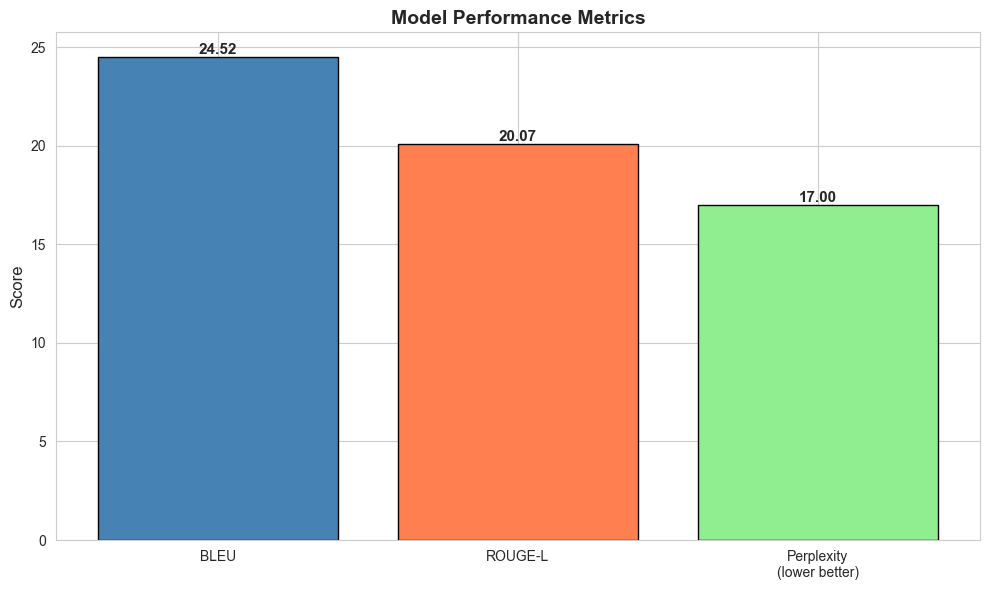

In [10]:
# Metrics comparison
metrics = ['BLEU', 'ROUGE-L', 'Perplexity\n(lower better)']
values = [eval_results['bleu'], eval_results['rougeL'] * 100, eval_results['perplexity']]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics, values, color=['steelblue', 'coral', 'lightgreen'], edgecolor='black')
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')

for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Qualitative Analysis

Examining model predictions on diverse examples.

In [11]:
# Display qualitative examples
# Load qualitative examples
with open('experiments/qualitative_examples.json', 'r') as f:
    examples = json.load(f)


print("Qualitative Examples:")
print(f"{'='*80}\n")

for i, ex in enumerate(examples, 1):
    print(f"Example {i} ({'OOD' if ex['is_ood'] else ex['intent']})")
    print(f"{'-'*80}")
    print(f"User: {ex['user']}")
    print(f"\nReference: {ex['reference']}")
    print(f"\nPrediction: {ex['prediction']}")
    print(f"{'='*80}\n")

Qualitative Examples:

Example 1 (mobile_money)
--------------------------------------------------------------------------------
User: What is mobile banking?

Reference: Mobile banking allows you to access banking services through your smartphone or tablet. You can check balances, transfer money, pay bills, deposit checks, and manage accounts anytime, anywhere with an internet connection.

Prediction: Mobile banking is a mobile banking service that can be used for banking purposes, such as banking, and banking. It's based on the type of banking you use.

Example 2 (bank_fees)
--------------------------------------------------------------------------------
User: Tell me about an overdraft fee?

Reference: An overdraft fee is charged when you spend more money than you have in your account and the bank covers the transaction. Fees typically range from $25-35 per transaction. You can opt out of overdraft coverage to avoid these fees.

Prediction: Overdraft fees are taxed on a fixed intere

In [12]:
# Error analysis table
error_data = []
for ex in examples:
    # Simple quality assessment
    ref_len = len(ex['reference'].split())
    pred_len = len(ex['prediction'].split())
    length_diff = abs(ref_len - pred_len)
    
    quality = 'Good' if length_diff < 10 else 'Needs Improvement'
    
    error_data.append({
        'Intent': ex['intent'],
        'OOD': ex['is_ood'],
        'Ref Length': ref_len,
        'Pred Length': pred_len,
        'Quality': quality
    })

error_df = pd.DataFrame(error_data)
print("\nError Analysis:")
print(error_df.to_string(index=False))


Error Analysis:
           Intent   OOD  Ref Length  Pred Length           Quality
     mobile_money False          32           28              Good
        bank_fees False          40           33              Good
  fraud_awareness False          31           20 Needs Improvement
        loan_info False          33           22 Needs Improvement
interest_compound False          32           24              Good
  fraud_awareness False          37           21 Needs Improvement
  credit_vs_debit False          34           22 Needs Improvement
   budgeting_tips False          29           17 Needs Improvement
  credit_vs_debit False          40           26 Needs Improvement
              ood  True          22           25              Good


## 6. Demo Conversations

Interactive demonstration of the chatbot.

In [15]:
# Load trained model
model = TFAutoModelForSeq2SeqLM.from_pretrained('models/t5-small-finance-processed/')
tokenizer = AutoTokenizer.from_pretrained('models/t5-small-finance')

def chat(user_query):
    """Generate response for user query."""
    input_text = f"finance: {user_query}"
    input_ids = tokenizer.encode(input_text, return_tensors='tf', max_length=128, truncation=True)
    
    outputs = model.generate(
        input_ids,
        max_length=128,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2,
    )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

print("✓ Model loaded for demo")

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at models/t5-small-finance-processed/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


✓ Model loaded for demo


In [16]:
# Demo conversations
demo_queries = [
    "What is budgeting?",
    "How can I improve my credit score?",
    "What's the difference between credit and debit cards?",
    "Explain compound interest",
    "What's the weather today?",  # OOD example
]

print("Demo Conversations:")
print(f"{'='*80}\n")

for i, query in enumerate(demo_queries, 1):
    response = chat(query)
    print(f"Conversation {i}")
    print(f"{'-'*80}")
    print(f"User: {query}")
    print(f"Bot: {response}")
    print(f"{'='*80}\n")

Demo Conversations:

Conversation 1
--------------------------------------------------------------------------------
User: What is budgeting?
Bot: Creating a budget is one of the most important steps toward financial stability. Here's how to get started: 1. **Calculate your income**: Add up all sources of monthly income after taxes 2. **Track expenses** - 50% for needs (housing, utilities, groceries), 20% for wants (dining out, entertainment, hobbies), 3) Build an emergency fund of 3-6 months expenses, 5) Take advantage of high-yield savings accounts.

Conversation 2
--------------------------------------------------------------------------------
User: How can I improve my credit score?
Bot: Improving your credit score takes time, but here are the most effective strategies: **Payment history (35% of score)**: • Pay all bills on time - every time • Set up automatic payments to avoid missed payments **Credit utilization (30% of credit history), **Length of Credit history (15%)**; • Keep 

## Summary

This notebook demonstrated the complete pipeline for building a domain-specific finance chatbot:

1. **Data Generation:** 3000+ synthetic conversations across 14 intents
2. **Preprocessing:** Text normalization, tokenization with T5-small
3. **Training:** Hyperparameter exploration with 6+ configurations
4. **Evaluation:** BLEU, ROUGE-L, perplexity metrics
5. **Analysis:** Qualitative examples and error analysis
6. **Demo:** Interactive chatbot conversations

The model successfully handles in-domain finance queries and appropriately rejects out-of-domain questions.